In [231]:
import pandas as pd
import numpy as np
import os

In [232]:
#################################################
# Data Cleaning
################################################

# Dowwnload longitude and latitude of each zip code
zip_codes_lat_long = pd.read_csv("zip_lat_long.csv") # https://simplemaps.com/data/us-zips
zip_codes_lat_long.head()

# Subset for calfornia
cali_lat_long = zip_codes_lat_long[zip_codes_lat_long["state_id"] == "CA"]
cali_lat_long.head()

# Keep only necessary columns
columns_to_keep = ["zip", "lat", "lng"]
cali_lat_long = cali_lat_long[columns_to_keep]
cali_lat_long.head()

,zip,lat,lng
30596,90001,33.97365,-118.24904
30597,90002,33.94906,-118.24679
30598,90003,33.96409,-118.27368
30599,90004,34.07624,-118.31101
30600,90005,34.05939,-118.30909


In [233]:
#################################################
# Merge the latitude/Longitude data into my data
################################################

# Load your original dataset
main_data = pd.read_csv("../20_Model/full_predictions_xgboost.csv")
#print(main_data.shape)
# Make sure ZIP columns are the same type (both int or both str)
main_data['ZIP_CODE'] = main_data['ZIP_CODE'].astype(str)
cali_lat_long['zip'] = cali_lat_long['zip'].astype(str)

# Merge lat/lon into your main data
merge_data = main_data.merge(cali_lat_long, 
    left_on='ZIP_CODE', 
    right_on='zip', 
    how='left',
    indicator = True)

# Now merge_data has ZIP_CODE, lat, lng, and all our original features
#merge_data["_merge"].value_counts()
merge_data = merge_data.drop(columns=["zip", "_merge"])

#print(merge_data.shape) # made sure no all columns 
merge_data.head(10)
merge_data.columns



Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK', 'YEAR_OF_LAST_FIRE', 'YEARS_SINCE_LAST_FIRE',
       'CUMULATIVE_ACRES_BURNED_LAST_3YRS', 'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
       'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
       'FIRE_EXPOSED_x_Median_Household_Income',
       'FIRE_EXPOSED_x_Below_Poverty_Rate', 'ROLLING_3yr_PRICE_CHANGE_STD',
       'PC

In [234]:
#################################################
# Calculate the distane between the center of each zip codes to burned zips for same year
################################################
from scipy.spatial.distance import cdist

# 1. Create empty list to store results
all_years_distances = []

# 2. Loop through each year
for year in merge_data['YEAR'].unique():
    #print(f"Processing year: {year}")

    # Filter to only rows from this year
    year_data = merge_data[merge_data['YEAR'] == year]

    # Burned and Not Burned ZIPs for this year
    burned_zips = year_data[year_data['FIRE_EXPOSED'] == 1][['ZIP_CODE', 'lat', 'lng']]
    not_burned_zips = year_data[year_data['FIRE_EXPOSED'] == 0][['ZIP_CODE', 'lat', 'lng']]

    # If no burned ZIPs this year, assign a big distance (or NaN)
    if burned_zips.empty:
        print(f"No fires in {year}, assigning NaN distances.")
        not_burned_zips['distance_to_burned_miles'] = np.nan
    else:
        # Calculate distance matrix
        distances = cdist(
            not_burned_zips[['lat', 'lng']],
            burned_zips[['lat', 'lng']],
            metric='euclidean'
        )

        # Find closest distance to any burned ZIP
        closest_distances = distances.min(axis=1)

        # Convert to miles (approximate)
        closest_distances_miles = closest_distances * 69

        # Attach distances
        not_burned_zips['distance_to_burned_miles'] = closest_distances_miles

    # Add year column back
    not_burned_zips['YEAR'] = year

    # Store
    all_years_distances.append(not_burned_zips[['ZIP_CODE', 'YEAR', 'distance_to_burned_miles']])

# 3. Combine all years together
distance_to_burned_all_years = pd.concat(all_years_distances, ignore_index=True)
distance_to_burned_all_years.head(20)

,ZIP_CODE,YEAR,distance_to_burned_miles
0,90001,2021,21.688506
1,90002,2021,22.465133
2,90003,2021,20.349829
3,90004,2021,16.119905
4,90005,2021,16.315642
5,90006,2021,17.428796
6,90007,2021,18.283408
7,90008,2021,14.744040
8,90010,2021,16.057136
9,90011,2021,20.378560


In [235]:
# 1. First, merge your distance back to your main data
spillover = merge_data.merge(
    distance_to_burned_all_years,
    on=['ZIP_CODE', 'YEAR'],
    how='left'
)

# 2. Create group labels
def assign_group(row):
    if row['FIRE_EXPOSED'] == 1:
        return "Directly Exposed"
    elif row['distance_to_burned_miles'] <= 15:
        return "Neighboring"
    else:
        return "Unaffected"

spillover['fire_spillover_group'] = spillover.apply(assign_group, axis=1)

# 3. Check!
spillover[['ZIP_CODE', 'YEAR', 'FIRE_EXPOSED', 'distance_to_burned_miles', 'fire_spillover_group']].head(20)


,ZIP_CODE,YEAR,FIRE_EXPOSED,distance_to_burned_miles,fire_spillover_group
0,90001,2021,0,21.688506,Unaffected
1,90002,2021,0,22.465133,Unaffected
2,90003,2021,0,20.349829,Unaffected
3,90004,2021,0,16.119905,Unaffected
4,90005,2021,0,16.315642,Unaffected
5,90006,2021,0,17.428796,Unaffected
6,90007,2021,0,18.283408,Unaffected
7,90008,2021,0,14.744040,Neighboring
8,90010,2021,0,16.057136,Unaffected
9,90011,2021,0,20.378560,Unaffected


In [236]:
spillover["fire_spillover_group"].value_counts()

fire_spillover_group
Unaffected          4163
Neighboring         1049
Directly Exposed     299
Name: count, dtype: int64

In [237]:
group_summary = spillover.groupby('fire_spillover_group')["PREDICTED_PCT_PRICE_CHANGE (%)"].agg(['mean', 'median', 'count']).reset_index()
print(group_summary)



  fire_spillover_group      mean    median  count
0     Directly Exposed  3.425299  2.554448    299
1          Neighboring  1.887335  0.371999   1049
2           Unaffected  3.767326  3.244650   4163


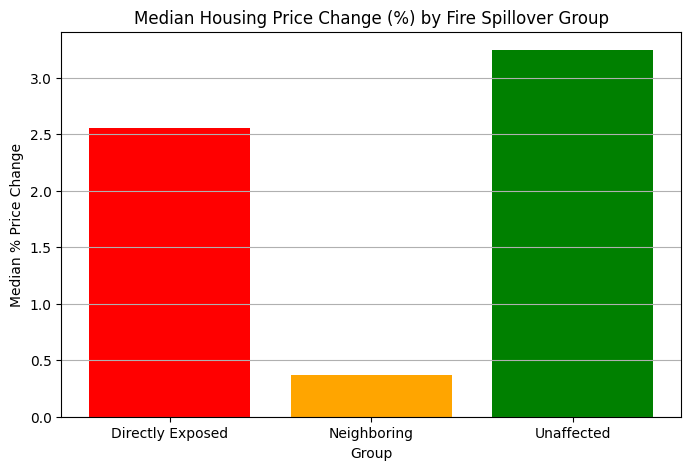

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(group_summary['fire_spillover_group'], group_summary['median'], color=['red', 'orange', 'green'])
plt.title('Median Housing Price Change (%) by Fire Spillover Group')
plt.ylabel('Median % Price Change')
plt.xlabel('Group')
plt.grid(axis='y')
plt.show()


In [239]:
from scipy.stats import ttest_ind

# 1. Split the groups
directly_exposed = spillover[spillover['fire_spillover_group'] == 'Directly Exposed']["PREDICTED_PCT_PRICE_CHANGE (%)"]
neighboring = spillover[spillover['fire_spillover_group'] == 'Neighboring']["PREDICTED_PCT_PRICE_CHANGE (%)"]
unaffected = spillover[spillover['fire_spillover_group'] == 'Unaffected']["PREDICTED_PCT_PRICE_CHANGE (%)"]

# 2. T-test: Neighboring vs Unaffected
tstat_neigh_unaff, pval_neigh_unaff = ttest_ind(neighboring, unaffected, equal_var=False)
print(f"T-test Neighboring vs Unaffected: t = {tstat_neigh_unaff:.4f}, p = {pval_neigh_unaff:.4f}")

# 3. T-test: Directly Exposed vs Unaffected
tstat_direct_unaff, pval_direct_unaff = ttest_ind(directly_exposed, unaffected, equal_var=False)
print(f"T-test Directly Exposed vs Unaffected: t = {tstat_direct_unaff:.4f}, p = {pval_direct_unaff:.4f}")


T-test Neighboring vs Unaffected: t = -5.9348, p = 0.0000
T-test Directly Exposed vs Unaffected: t = -0.4882, p = 0.6257
